# End-To-End Training Example of RNN for rain estimation and detection using PyNNCML
This notebook presents an end-to-end example of training a Recurrent Neural Network (RNN) based rain estimation neural network [1] on the openMRG dataset.
This tutorial is built using the PyNNCML software package, which provides both tools to simplify the training process of deep learning models for CMLs.
We start with obtaining a subset of the OpenMRG dataset and splitting it into training and validation datasets.
Afterward, we construct the One Step Network from [1], followed by the training loop.
Finally, we analyze the model performance in terms of RMSE and Bias.


Notebook structure
1. Imports and Installation of PyNNCML
2. Hyperparameter settings
3. Build Dataset
4. Build Neural Network
5. Training Loop
6. Neural Network Analysis


[Run this notebook in colab](https://colab.research.google.com/github/haihabi/PyNNcml/blob/master/examples/training_rnn.ipynb)

To run this notebook on Colab using GPU, please do the following:
Runtime -> Change runtime type -> Select GPU -> Save


In [15]:
import sys
import os

if os.path.exists('../../pynncml'):
    print("Import PyNNCML From Code")
    sys.path.append('../../')  # This line is need to import pynncml
else:
    print("Install PyNNCML From pip")
    !pip install pynncml

import pynncml as pnc
import torch
from matplotlib import pyplot as plt
import random
import numpy as np

np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

Import PyNNCML From Code


In [16]:
batch_size = 32
window_size = 32
lr = 1e-4
n_epochs = 200
xy_min = [1.29e6, 0.565e6]  # Link Region
xy_max = [1.34e6, 0.5875e6]
xy_min = None
xy_max = None
time_slice = slice("2015-06-01", "2015-08-14")  # Time Interval

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
score_training = True

# Building Training and Validation datasets

File already exists at desired location ./data/OpenMRG.zip
Not downloading!


100%|██████████| 728/728 [01:15<00:00,  9.67it/s]


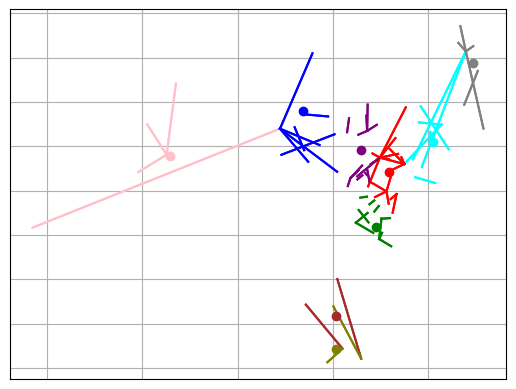

In [17]:
dataset_base = pnc.datasets.loader_open_mrg_dataset(xy_min=xy_min, xy_max=xy_max, time_slice=time_slice)
dataset = pnc.datasets.linkdataset2subsequent(dataset_base)
dataset_base.link_set.plot_links()
plt.grid()
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
plt.show()

training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])
data_loader_all = torch.utils.data.DataLoader(dataset_base, batch_size)
data_loader = torch.utils.data.DataLoader(training_dataset, batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size)

# Prior

(0.10000000000000002, 1.2786346500589536) (0.20999060463299707, 1.3877784166011313e-17, 3.5238266566618135)


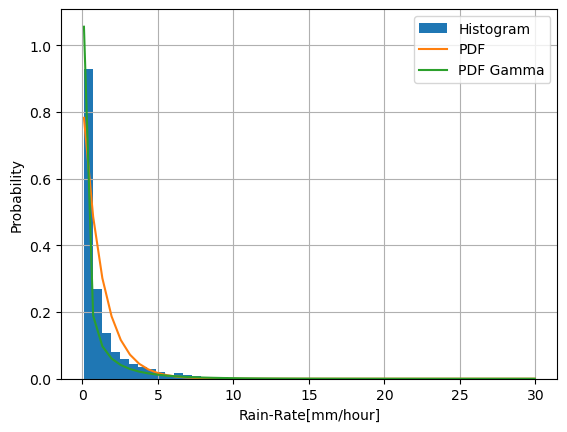

0.10000000000000002 29.959999999999997 1.3786346500589537


In [18]:
rain_data = np.asarray(dataset.label)
from scipy.stats import expon, gamma

res = expon.fit(rain_data)
res_gamma = gamma.fit(rain_data - 0.1)
print(res, res_gamma, )
min_r, max_r, mean_r = np.min(rain_data), np.max(rain_data), np.mean(rain_data)
r_array = np.linspace(min_r, max_r)
plt.hist(rain_data, density=True, bins=50, label="Histogram")
plt.plot(r_array, expon.pdf(r_array, loc=res[0], scale=res[1]), label="PDF")
plt.plot(r_array, gamma.pdf(r_array, a=res_gamma[0], loc=0, scale=res_gamma[2]), label="PDF Gamma")
plt.grid()
plt.legend()
plt.xlabel("Rain-Rate[mm/hour]")
plt.ylabel("Probability")
plt.show()

shift = float(res[0])
scale = float(res[1])
print(min_r, max_r, mean_r)


def score_func(in_theta):
    return -1 / scale



# Neural Network

In [19]:

from examples.rain_score.conformer.mlp import MLP
from examples.rain_score.conformer.conditional_encoder import RainScoreConformer
from examples.rain_score.conformer.encoder import RainConformer
from torch import nn

model_prior = MLP(3, 1, 1, 196, nn.SiLU,
                  bias_output=False, normalization=None, residual=False).to(
    device)

if score_training:
    model = RainScoreConformer(normalization_cfg=pnc.training_helpers.compute_data_normalization(data_loader_all)).to(
        device)
else:
    model = RainConformer().to(device)
model.load_state_dict(torch.load("model_score_ema_best.pkl"))
model_prior.load_state_dict(torch.load("model_score_prior_ema.pkl"))
# model.load_state_dict(torch.load("model_score_ema_best.pkl"))
# torch.save(imt_score.score_model_ema_best.state_dict(), "model_score_ema_best.pkl")


<All keys matched successfully>

# Model Validation

100%|██████████| 200/200 [00:00<00:00, 322.06it/s]


----------------------------------------------------------------------------------------------------
1.5921256538583364 tensor(0.3652, device='cuda:0')
1.154856838822565 tensor(0.2649, device='cuda:0')


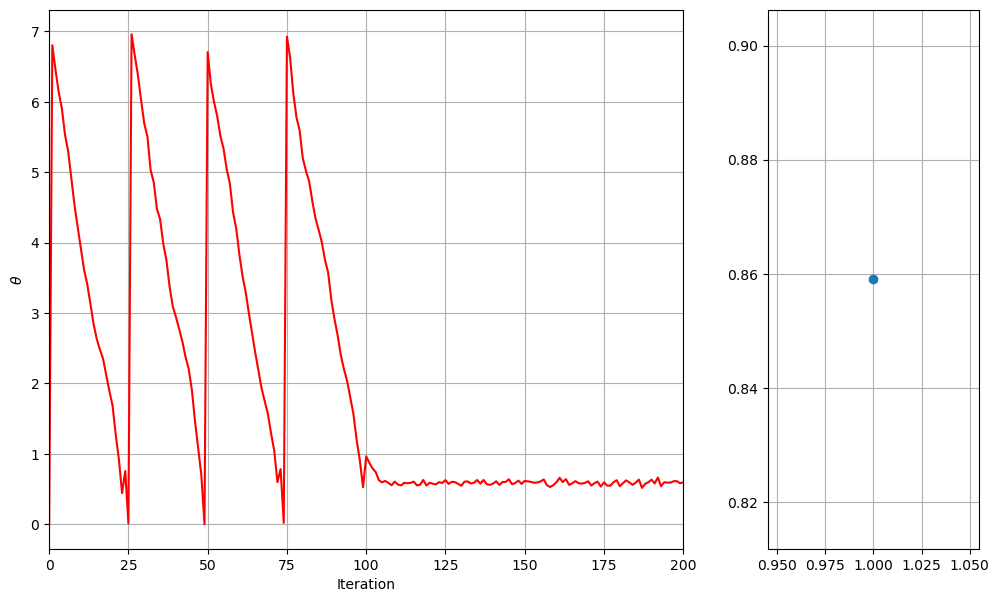

In [30]:
import math
from examples.rain_score.score.diffusion_inference import DiffusionMLE, Domain

ga = pnc.analysis.GroupAnalysis()
model.eval()
am = pnc.analysis.AverageMetric()
domain = Domain(torch.zeros(1), torch.inf * torch.ones(1)).to(device)

mse = 0
bias = 0
count = 0
for rain_rate, data, metadata in val_loader:

    data = data.to(device)
    metadata = metadata.to(device)
    rain_rate = rain_rate.reshape([-1, 1]).float().to(device)
    if score_training:
        def score(_x, _in_labels):
            _score, _ = model(_x, metadata.to(device), _in_labels)
            return _score


        dmle = DiffusionMLE(score,
                            1,
                            0.4,
                            "_in_labels", in_domain=domain, beta=100, n_iterations=200, adaptive_lr=False, n_stages=2)

    if score_training:
        _rr = rain_rate.reshape([-1, 1])
        dmle.set_labels(_in_labels=_rr)
        rain_hat, _, _, _, _ = dmle.estimate(data.to(device), initialization_point=torch.ones_like(_rr) * 0.0)
        ga.append(_rr.detach().cpu().numpy(), rain_hat.detach().cpu().numpy())
        delta = _rr - rain_hat
        mse += torch.mean(delta ** 2).item()
        bias += torch.mean(delta)
        count += 1

print("-" * 100)
print(math.sqrt(mse / count), bias / count)
print(math.sqrt(mse / count) / mean_r, (bias / count) / mean_r)
dmle.plot_debug()



In [21]:
ga_dmle = pnc.analysis.GroupAnalysis()
am = pnc.analysis.AverageMetric()

mse = 0
bias = 0
count = 0
for rain_rate, data, metadata in val_loader:

    data = data.to(device)
    metadata = metadata.to(device)
    rain_rate = rain_rate.reshape([-1, 1]).float().to(device)
    if score_training:
        def score(_x, _in_labels):
            s_hat, s_prior = model(_x, metadata.to(device), _in_labels)
            return s_hat - s_prior


        dmle = DiffusionMLE(score,
                            1,
                            0.02,
                            "_in_labels", in_domain=domain, beta=1, n_iterations=200, n_stages=2)

    if score_training:
        _rr = rain_rate.reshape([-1, 1])
        dmle.set_labels(_in_labels=_rr)
        rain_hat, _, _, _, _ = dmle.estimate(data.to(device), initialization_point=torch.ones_like(_rr) * 0.0)
        ga_dmle.append(_rr.detach().cpu().numpy(), rain_hat.detach().cpu().numpy())
        delta = _rr - rain_hat

        mse += torch.mean(delta ** 2).item()
        bias += torch.mean(delta)
        count += 1

print("-" * 100)
print(math.sqrt(mse / count), bias / count)
print(math.sqrt(mse / count) / mean_r, (bias / count) / mean_r)

100%|██████████| 200/200 [00:00<00:00, 292.21it/s]

----------------------------------------------------------------------------------------------------
1.9458077608370654 tensor(-0.2157, device='cuda:0')
1.4114020424148328 tensor(-0.1565, device='cuda:0')


-------------------------------------------------- Results Summery --------------------------------------------------
+--------------+-------------+-------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
|    Metric    |   0<r<0.2   |  0.2<r<0.4  |  0.6<r<0.8   |  0.8<r<1   |   1<r<2    |   2<r<3    |   3<r<4    |   4<r<5    |   5<r<6    |   6<r<7    |  7<r<inf   |
+--------------+-------------+-------------+--------------+------------+------------+------------+------------+------------+------------+------------+------------+
|     RMSE     |  0.42353585 |  0.3943686  |  0.71596104  | 0.80316836 | 1.1722893  | 1.6214827  | 2.1636977  | 2.5311909  | 2.7896247  | 3.3464048  |  7.186735  |
|     BIAS     | -0.23031425 | -0.11656759 | 0.0021955005 | 0.14789249 | 0.26107502 | 0.6753053  |  1.450411  | 1.7378442  |  2.129421  | 2.8690753  |  6.079631  |
|    NRMSE     |   2.721549  |  1.3500124  |  1.0380312   | 0.

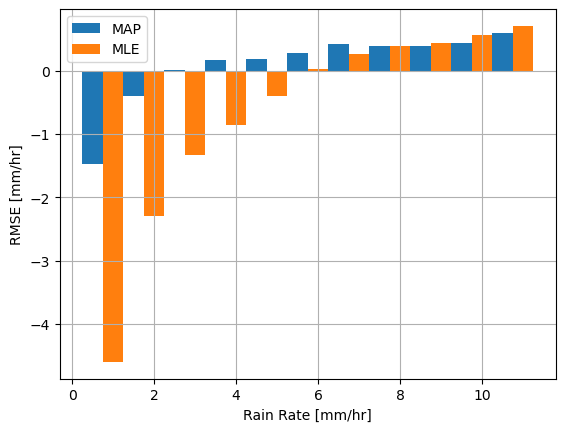

In [22]:
group_selection = [(0, 0.2), (0.2, 0.4), (0.6, 0.8), (0.8, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7),
                   (7, np.inf)]

rmse, bias, group_d = ga.run_analysis(group_selection)
plt.bar(np.linspace(0, len(rmse) - 1, len(rmse)) + 0.5, height=bias, width=0.5, label="MAP")
rmse, bias, group_d = ga_dmle.run_analysis(group_selection)
plt.bar(np.linspace(0, len(rmse) - 1, len(rmse)) + 1.0, height=bias, width=0.5, label="MLE")
plt.grid()
plt.legend()
plt.ylabel("RMSE [mm/hr]")
plt.xlabel("Rain Rate [mm/hr]")
plt.show()

In [23]:
ref, est = group_d[0]

In [24]:
est

array([0.19287314, 0.02777383, 1.1935431 , ..., 2.4373972 , 0.4737926 ,
       3.8881397 ], dtype=float32)